### Hookean Triplet

In [1]:
from __future__ import annotations
from dataclasses import dataclass

import jax
import jax.numpy as jnp
from jax.tree_util import register_dataclass
import jaxtyping
import optax
import matplotlib.pyplot as plt
import numpy as np

import hodel


@register_dataclass
@dataclass
class TripletAux:
    """parametrized external force."""

    f: jax.Array
    c: jax.Array


@register_dataclass
@dataclass
class Triplet:
    """3 node spring where Theta is [K_1, K_2]"""

    l_k: jax.Array

    @classmethod
    def init(cls, xf0: jax.Array, xb0: jax.Array) -> Triplet:
        x0 = xb0[0]
        x1, x2 = xf0
        return cls(jnp.array([x1 - x0, x2 - x1]))

    @staticmethod
    def get_strain(x0, x1, x2, l_k) -> jax.Array:
        return jnp.array([x1 - x0, x2 - x1]) / l_k

    def get_K(self, del_strain: jax.Array, Theta: jaxtyping.PyTree) -> jax.Array:
        return jnp.diag(jnp.abs(Theta))

    def get_energy(
        self,
        xf: jax.Array,
        xb: jax.Array,
        Theta: jax.Array,
        aux: TripletAux,
    ) -> jax.Array:
        # xb = [x0], xf = [x1, x2]
        x0 = xb[0]
        x1, x2 = xf
        del_strain = self.get_strain(x0, x1, x2, self.l_k) - 1.0
        return 0.5 * del_strain @ self.get_K(del_strain, Theta) @ del_strain


def get_W(lambda_: jax.Array, aux: TripletAux):
    return lambda_ * aux.f + aux.c


def fixed_0(lambda_: jax.Array, aux: TripletAux) -> jax.Array:
    return jnp.array([0.0])


# Setup
# xf0 controls natural position
xf0 = jnp.array([1.0, 2.0])
energy = Triplet.init(xf0, jnp.array([0.0]))
sim = hodel.HODEL(energy.get_energy, get_W, fixed_0)

# force is setup to mimic gravity + lambda-varying load
# assume total spring weighs 0.03 kg and each node has equal contribution
aux = TripletAux(jnp.array([0.0, 10.0]), jnp.array([9.81 * 1e-2, 9.81 * 1e-2]))
Theta_star = jnp.array([5.0, 2.0])

print("λ=0: ", sim.solve(jnp.array([0.0]), xf0, Theta_star, aux))
print("λ=1: ", sim.solve(jnp.array([1.0]), xf0, Theta_star, aux))

λ=0:  [1.03924 2.08829]
λ=1:  [3.03924 9.08829]


#### Learn Constant K

In [2]:
lambdas = jnp.linspace(0, 1, 10)
batch_aux = jax.vmap(TripletAux)(
    jnp.array([[0.0, 10.0], [10.0, 0.0]]),
    jnp.array([[9.81 * 1e-2, 9.81 * 1e-2], [9.81 * 1e-2, 9.81 * 1e-2]]),
)
xf_stars = jax.vmap(lambda aux_: sim.sim(lambdas, xf0, Theta_star, aux_))(batch_aux)
key = jax.random.PRNGKey(0)
Theta0 = jax.random.uniform(key, [2], minval=1e-1, maxval=1e1)
lr = 2e-1
nepochs = 100

final_Theta, L = sim.batch_learn(
    lambdas, xf0, xf_stars, Theta0, batch_aux, optim=optax.adam(lr), nepochs=nepochs
)

print("True Theta:", Theta_star)
print("Theta0:", Theta0)
print("Final Theta:", final_Theta)

True Theta: [5. 2.]
Theta0: [9.481903 9.787941]
Final Theta: [4.9337397 2.0004742]


### Non-linear Triplet

In [3]:
import flax.linen as nn


@register_dataclass
@dataclass
class KSTriplet(Triplet):
    def get_K(self, del_strain, Theta):
        # Theta = [K0_1, alpha_1, K0_2, alpha_2]
        K0_1, alpha_1, K0_2, alpha_2 = Theta
        K1 = K0_1 * jnp.exp(alpha_1 * del_strain[0])
        K2 = K0_2 * jnp.exp(alpha_2 * del_strain[1])
        return jnp.diag(jnp.array([K1, K2]))


Theta_star = jnp.array([5.0, 0.4, 2.0, 0.8])
ks_energy = KSTriplet.init(xf0, jnp.array([0.0]))
ks_sim = hodel.HODEL(ks_energy.get_energy, get_W, fixed_0)


class KNet(nn.Module):
    """Simple 2 x 2 PSD module"""

    hidden_size: int

    @nn.compact
    def __call__(self, del_strain):
        x = nn.softplus(nn.Dense(self.hidden_size)(del_strain))
        x = nn.softplus(nn.Dense(self.hidden_size)(x))
        # Initialize bias to K=4 to make first executions reasonable.
        # Kernel to 0 is just experimental. It makes the first run strictly DER.
        x = nn.Dense(
            2,
            kernel_init=nn.initializers.zeros,
            bias_init=nn.initializers.constant(4.0),
        )(x)
        a, b = x
        a = jax.nn.softplus(a)
        b = jax.nn.softplus(b)
        return jnp.array([[a, 0.0], [0.0, b]])

    @nn.compact
    def psd(self, del_strain):
        # Unused, off diagonals were messing things up but with proper init it should probably work
        x = nn.softplus(nn.Dense(self.hidden_size)(del_strain))
        x = nn.softplus(nn.Dense(self.hidden_size)(x))
        x = nn.Dense(
            3,
            kernel_init=nn.initializers.zeros,
            bias_init=nn.initializers.constant(4.0),
        )(x)
        a, b, c = x
        a = jax.nn.softplus(a)
        c = jax.nn.softplus(c)
        L = jnp.array([[a, 0.0], [b, c]])
        return L @ L.T


model = KNet(10)


@register_dataclass
@dataclass
class NNTriplet(Triplet):
    """3 node spring where Theta is parameters for a neural network."""

    def get_K(self, del_strain: jax.Array, Theta: nn.FrozenDict) -> jax.Array:
        return model.apply(Theta, del_strain)  # type: ignore


# TODO: Figure out how to make this more seamless

params = model.init(key, jnp.zeros(2))
nn_energy = NNTriplet.init(xf0, jnp.array([0.0]))
nn_sim = hodel.HODEL(nn_energy.get_energy, get_W, fixed_0)

print(
    "λ=0: ",
    nn_sim.solve(jnp.array([0.0]), xf0, params, aux),
    ks_sim.solve(jnp.array([0.0]), xf0, Theta_star, aux),
)
print(
    "λ=1: ",
    nn_sim.solve(jnp.array([1.0]), xf0, params, aux),
    ks_sim.solve(jnp.array([1.0]), xf0, Theta_star, aux),
)

λ=0:  [1.0488285 2.0732427] [1.0383486 2.08475  ]
λ=1:  [3.537536  7.0506577] [2.0854094 4.330374 ]


truth:  [[1.0383486 2.08475  ]
 [1.2282318 2.6132581]
 [1.3850032 2.972279 ]
 [1.5194868 3.255288 ]
 [1.6377859 3.4922714]
 [1.7437203 3.697629 ]
 [1.839857  3.8796241]
 [1.9280123 4.04352  ]
 [2.0095243 4.19291  ]
 [2.0854094 4.330374 ]]
nn:  [[1.036865  2.0784466]
 [1.2362556 2.6168358]
 [1.3939052 2.9763947]
 [1.5228957 3.2497675]
 [1.6353747 3.478902 ]
 [1.7373905 3.6818283]
 [1.8320833 3.8673143]
 [1.9212245 4.0401316]
 [2.005895  4.2031264]
 [2.0868034 4.3581324]]


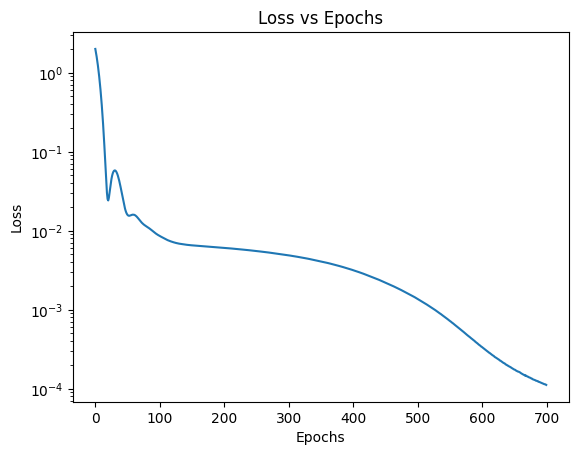

In [4]:
batch_aux = jax.vmap(TripletAux)(
    jnp.array([[0.0, 10.0], [10.0, 0.0]]),
    jnp.array([[9.81 * 1e-2, 9.81 * 1e-2], [9.81 * 1e-2, 9.81 * 1e-2]]),
)
xf_stars = jax.vmap(lambda aux_: ks_sim.sim(lambdas, xf0, Theta_star, aux_))(batch_aux)

lr = 1e-2
nepochs = 700
# schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=n_epochs, alpha=0.2)

final_params, L = nn_sim.batch_learn(
    lambdas, xf0, xf_stars, params, batch_aux, optim=optax.adam(lr), nepochs=nepochs
)
final_xfs = nn_sim.sim(lambdas, xf0, final_params, aux)

print("truth: ", xf_stars[0])
print("nn: ", final_xfs)

plt.plot(L)
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

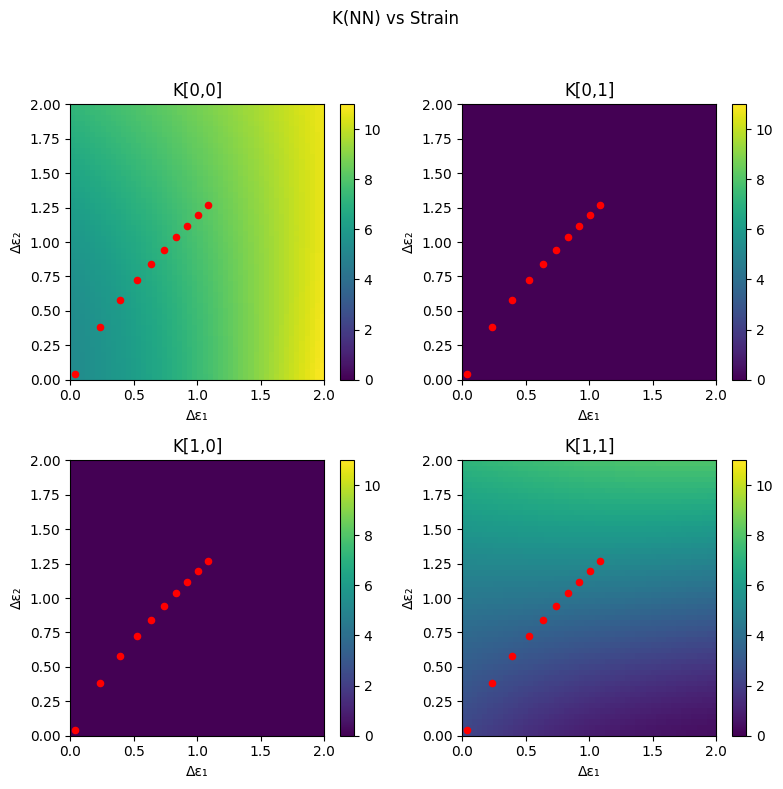

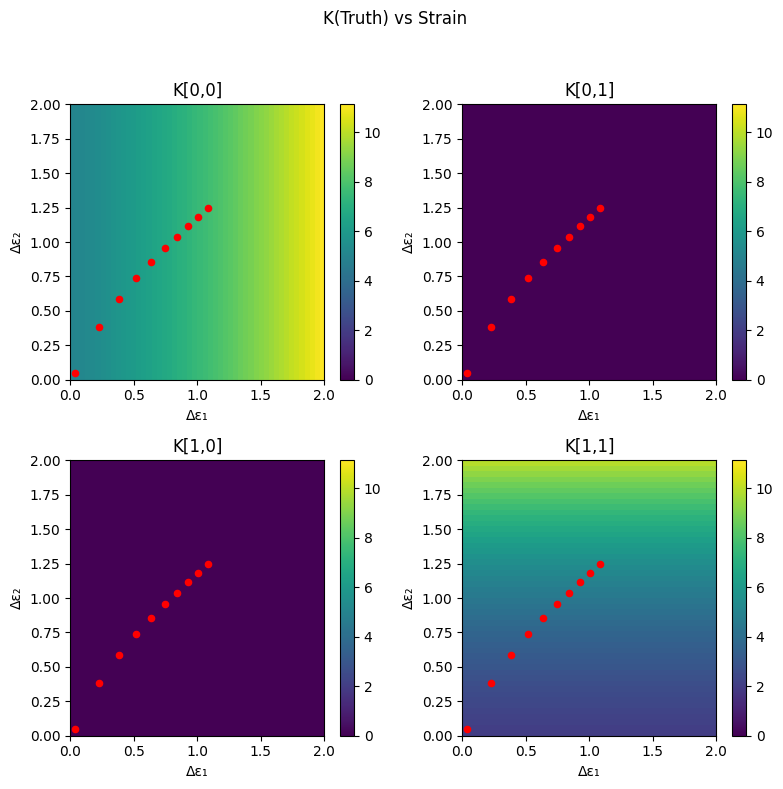

In [5]:
# Range of del_strains
del_strains = []
for x1, x2 in final_xfs:
    del_strains.append(nn_energy.get_strain(0, x1, x2, nn_energy.l_k) - 1.0)
del_strains = jnp.stack(del_strains)

ks_del_strains = []
for x1, x2 in xf_stars[0]:
    ks_del_strains.append(ks_energy.get_strain(0, x1, x2, nn_energy.l_k) - 1.0)
ks_del_strains = jnp.stack(ks_del_strains)

# Get grid for heatmap
eps1_min, eps2_min = del_strains.min(0)
eps1_max, eps2_max = del_strains.max(0)
eps1 = jnp.linspace(jnp.floor(eps1_min), jnp.ceil(eps1_max), 50)
eps2 = jnp.linspace(jnp.floor(eps2_min), jnp.ceil(eps2_max), 50)
E1, E2 = jnp.meshgrid(eps1, eps2)
del_strains_map = jnp.stack([E1.ravel(), E2.ravel()], axis=-1)

# Generate map of Ks
nn_K = jax.vmap(lambda s: nn_energy.get_K(s, final_params))(del_strains_map)
ks_K = jax.vmap(lambda s: ks_energy.get_K(s, Theta_star))(del_strains_map)


def visualize_K(K, del_strains, suptitle="K vs Strains"):
    K11 = K[:, 0, 0].reshape(E1.shape)
    K12 = K[:, 0, 1].reshape(E1.shape)
    K21 = K[:, 1, 0].reshape(E1.shape)
    K22 = K[:, 1, 1].reshape(E1.shape)

    Ks = [K11, K12, K21, K22]
    titles = ["K[0,0]", "K[0,1]", "K[1,0]", "K[1,1]"]

    vmin = min(np.min(Kij) for Kij in Ks)
    vmax = max(np.max(Kij) for Kij in Ks)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.flatten()

    for ax, Kij, title in zip(axs, Ks, titles):
        im = ax.imshow(
            np.asarray(Kij),
            extent=(eps1.min(), eps1.max(), eps2.min(), eps2.max()),
            origin="lower",
            cmap="viridis",
            aspect="auto",
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_xlabel("Δε₁")
        ax.set_ylabel("Δε₂")
        ax.scatter(
            del_strains[:, 0],
            del_strains[:, 1],
            color="red",
            s=20,
            marker="o",
            label="Equilibria",
        )
        ax.set_title(title)
        fig.colorbar(im, ax=ax)

    fig.suptitle(suptitle)
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))  # keep suptitle visible
    # fig.savefig(f"{suptitle}.png", dpi=300, bbox_inches='tight')
    plt.show()


visualize_K(nn_K, del_strains, "K(NN) vs Strain")
visualize_K(ks_K, ks_del_strains, "K(Truth) vs Strain")

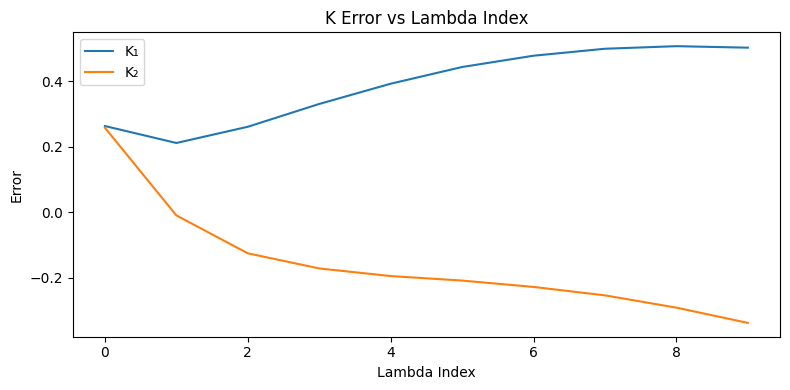

In [6]:
def visualize_K_diff(nn: Triplet, truth: Triplet, del_strains) -> None:
    error = jax.vmap(lambda s: nn.get_K(s, final_params) - truth.get_K(s, Theta_star))(
        del_strains
    )
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(error[:, 0, 0], label="K₁")
    ax.plot(error[:, 1, 1], label="K₂")
    ax.legend()
    ax.set_title("K Error vs Lambda Index")
    ax.set_ylabel("Error")
    ax.set_xlabel("Lambda Index")
    fig.tight_layout()
    # fig.savefig("test.png", dpi=300, bbox_inches='tight')
    plt.show()


visualize_K_diff(nn_energy, ks_energy, del_strains)